# Ethereum Historical Data
#### Ethereum data at 1-Day intervals from select exchanges, Mar 2016 to Aug 02, 2020 
<img src="https://seeklogo.com/images/E/ethereum-logo-1C9A722BB1-seeklogo.com.png" width="500" height="500" align="center">
<br>
<br>

> Ethereum is the second-largest cryptocurrency platform by market capitalization, behind Bitcoin. It is a decentralized open-source blockchain featuring smart contract functionality. Ether is the cryptocurrency generated by Ethereum miners as a reward for computations performed to secure the blockchain.
<br><br>

# Upvote my kernel if you like my work.

## Table of contents
* Preprocessing the data
* Ethereum Price by year wise
* Monthly total for stock values
* Year wise report on Change %
* Volume flow by year wise 
* Auto-correlation and Partial-correlation
* Statistic and P-value
* Preprocessing the data for Recurrent Neural Network
* Building and fitting the LSTM model to the train dataset
* Comparing the model with actual value and predicted value


# Importing Modules

In [1]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, Embedding ,Dropout
from keras.layers import LSTM 
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

Using TensorFlow backend.


# Importing dataset

In [2]:
df=pd.read_csv("../data/input/Ethereum Historical Data.csv")

# 1. Preprocessing the data

In [3]:
df["Vol."]=df["Vol."].str.replace("-","0")
df["Vol."] = (df["Vol."].replace(r'[KMB]+$', '', regex=True).astype(float) * df["Vol."].str.extract(r'[\d\.]+([KMB]+)', expand=False).fillna(1).replace(['K','M', 'B'], [10**3, 10**6, 10**9]).astype(int))
df["Price"]=df["Price"].str.replace(",","")
df["Price"]=df["Price"].astype("float")
df["Open"]=df["Open"].str.replace(",","")
df["Open"]=df["Open"].astype("float")
df["High"]=df["High"].str.replace(",","")
df["High"]=df["High"].astype("float")
df["Low"]=df["Low"].str.replace(",","")
df["Low"]=df["Low"].astype("float")
df["Change %"]=df["Change %"].str.replace("%","")
df["Change %"]=df["Change %"].astype("float")

# 2. Ethereum Price by year wise

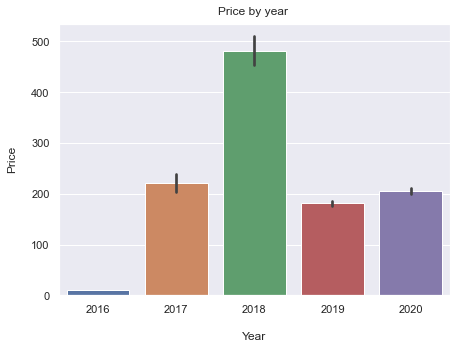

In [4]:
df['Date']= pd.to_datetime(df['Date'], format="%b %d, %Y")
df = df.sort_values(by='Date', ascending=True)
df.index = df.Date
del df["Date"]
sns.set(rc={'figure.figsize':(7,5)})
sns.barplot(x=df.index.year, y=df["Price"], data=df)
plt.xlabel("Year", labelpad=17)
plt.ylabel("Price", labelpad=14)

plt.title("Price by year ", y=1.01);

# 3. Monthly total for stock values

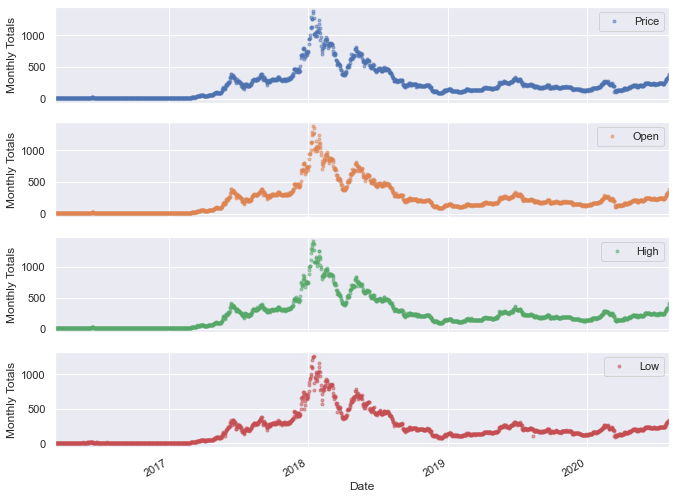

In [5]:
cols_plot = ["Price","Open","High","Low"]
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Monthly Totals')

# 4. Year wise report on Change %

Text(0.5, 1.0, 'Year wise report on Change %')

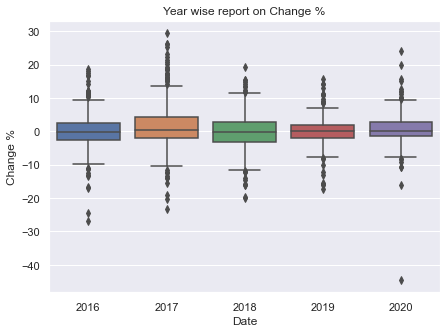

In [6]:
sns.boxplot(data=df, x=df.index.year, y=df["Change %"])
plt.title("Year wise report on Change %")

# 5. Volume flow by year wise 

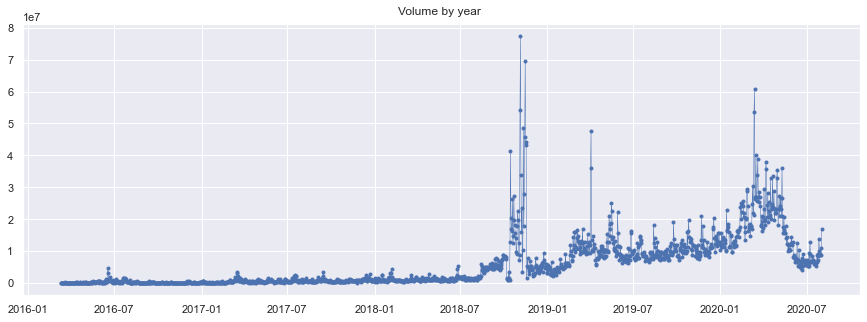

In [7]:
sns.set(rc={'figure.figsize':(15,5)})
start, end = '2016', '2020'
plt.plot(df.loc[start:end, 'Vol.'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
plt.title("Volume by year ", y=1.01);

# 6. Auto-correlation and Partial-correlation

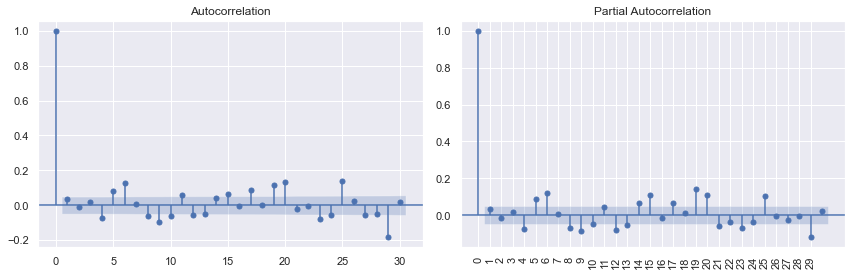

In [8]:
data=df["Price"]

feature_ts_train_diff = data.diff(periods=1)
feature_ts_train_diff.dropna(inplace=True)

feature_ts_train_diff

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
plt.xticks(range(0,30,1), rotation = 90)
smt.graphics.plot_acf(feature_ts_train_diff, lags=30, ax=axes[0])
smt.graphics.plot_pacf(feature_ts_train_diff, lags=30, ax=axes[1])
plt.tight_layout()

### we can see the negative correlation with partial and autocorrelation.

# 7. Statistic and P-value

In [9]:
dftest = adfuller(data)
print("Statistics",dftest[0])
fig = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = dftest[1],
    title = {'text': "P value"},
    domain = {'x': [0, 1], 'y': [0, 1]}
))


fig.show()

Statistics -2.444765191098683


### p-value > 0.05: Does not Rejects the null hypothesis (H0), the data have a unit root and is stationary.

# 8. Preprocessing the data for Recurrent Neural Network

In [10]:
ethe_train = data.iloc[0:1260].values
ethe_test = data.iloc[1260:].values

ethe_train=ethe_train.reshape(-1, 1)
scaler = MinMaxScaler(feature_range = (0, 1))

ethe_training_scaled = scaler.fit_transform(ethe_train)

ethe_training_scaled

features_set = []
labels = []
for i in range(60, 1260):
    features_set.append(ethe_training_scaled[i-60:i, 0])
    labels.append(ethe_training_scaled[i, 0])

features_set, labels = np.array(features_set), np.array(labels)


features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

# 9. Building and fitting the LSTM model to the train dataset

In [11]:
model = Sequential()


model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(features_set, labels, epochs = 50, batch_size = 32)


Epoch 1/50


ResourceExhaustedError:  OOM when allocating tensor with shape[32,50] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node lstm_1/while/body/_1/mul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_5043]

Function call stack:
keras_scratch_graph


# 10. Comparing the model with actual value and predicted value


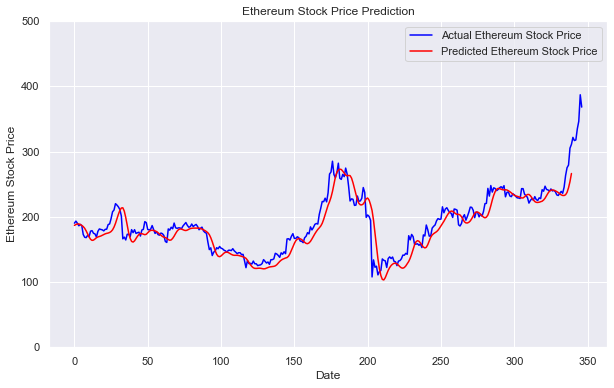

In [50]:
test_inputs = data[len(data) - len(ethe_test) - 60:].values


test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

test_features = []
for i in range(60, 400):
    test_features.append(test_inputs[i-60:i, 0])

test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

predictions = model.predict(test_features)
predictions = scaler.inverse_transform(predictions)


plt.figure(figsize=(10,6))
plt.plot(ethe_test, color='blue', label='Actual Ethereum Stock Price')
plt.plot(predictions , color='red', label='Predicted Ethereum Stock Price')
plt.title('Ethereum Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Ethereum Stock Price')
plt.ylim(0,500)
plt.legend()
plt.show()

## Here , Actual and Predicted Ethereum price are being plotted, we can clearly see that RNN(LSTM) Model worked Good in this dataset.

